In [5]:
import os
import cv2
import numpy as np
import mediapipe as mp
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv, global_mean_pool
from sklearn.metrics import accuracy_score
from lion_pytorch import Lion  # Lion Optimizer

In [2]:
# Remove Mac .DS_Store files
def clean_dataset_path(path):
    for root, dirs, files in os.walk(path):
        for file in files:
            if file == ".DS_Store":
                os.remove(os.path.join(root, file))

clean_dataset_path("DATASET")

In [7]:
# Initialize BlazePose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

In [9]:
# Define skeletal connections (with additional higher-order edges)
BLAZEPOSE_EDGES = [
    (0, 1), (1, 2), (2, 3), (3, 7), (0, 4), (4, 5), (5, 6), (6, 8),
    (9, 10), (11, 12), (11, 13), (13, 15), (15, 17), (17, 19), (19, 21),
    (12, 14), (14, 16), (16, 18), (18, 20), (20, 22),
    (11, 23), (12, 24), (23, 24), (23, 25), (24, 26),
    (25, 27), (26, 28), (27, 29), (28, 30),
    (31, 32), (0, 9), (0, 10), (11, 14), (12, 13),
    (0, 23), (0, 24), (11, 24), (12, 23)
]

In [11]:
# Extract keypoints with additional velocity-based features
def extract_keypoints(image, prev_keypoints=None):
    results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.pose_landmarks:
        landmarks = results.pose_landmarks.landmark
        keypoints = np.array([[l.x, l.y, l.z, l.visibility] for l in landmarks])
        
        # Normalize pose
        keypoints[:, :3] = (keypoints[:, :3] - np.mean(keypoints[:, :3], axis=0)) / (np.std(keypoints[:, :3], axis=0) + 1e-8)

        # Normalize visibility separately
        keypoints[:, 3] = keypoints[:, 3] / np.max(keypoints[:, 3])

        # Compute velocity features
        if prev_keypoints is not None:
            velocity = keypoints[:, :3] - prev_keypoints[:, :3]
            velocity = (velocity - np.mean(velocity, axis=0)) / (np.std(velocity, axis=0) + 1e-8)
        else:
            velocity = np.zeros_like(keypoints[:, :3])  # No velocity for first frame

        keypoints = np.hstack((keypoints, velocity))
        return keypoints.flatten()
    else:
        return np.zeros(33 * 7)  # 7 features per keypoint

In [13]:
# Convert keypoints into a graph
def keypoints_to_graph(keypoints, label):
    x = torch.tensor(keypoints, dtype=torch.float).view(33, -1)
    edge_index = torch.tensor(BLAZEPOSE_EDGES, dtype=torch.long).t().contiguous()
    y = torch.tensor([label], dtype=torch.long)
    return Data(x=x, edge_index=edge_index, y=y)

In [15]:
# Prepare dataset graphs
def process_dataset_to_graphs():
    all_graphs = {}
    for dataset_type in ["TRAIN", "TEST"]:
        data_dir = f"DATASET/{dataset_type.upper()}"
        dataset_graphs = []
        label_map = {asana: idx for idx, asana in enumerate(os.listdir(data_dir))}
        
        for asana in os.listdir(data_dir):
            asana_path = os.path.join(data_dir, asana)
            label = label_map[asana]
            prev_keypoints = None  # Track previous frame

            for img_file in sorted(os.listdir(asana_path)):  # Sorted for temporal consistency
                img_path = os.path.join(asana_path, img_file)
                image = cv2.imread(img_path)
                if image is not None:
                    keypoints = extract_keypoints(image, prev_keypoints)
                    prev_keypoints = keypoints.reshape(33, -1)[:, :3]  # Store only x,y,z for velocity calc
                    graph = keypoints_to_graph(keypoints, label)
                    dataset_graphs.append(graph)

        all_graphs[dataset_type] = dataset_graphs
        print(f"Graph data preparation for {dataset_type} dataset complete!")
    return all_graphs, label_map

In [17]:
# Define an improved YogaPoseGAT Model
class YogaPoseGAT(torch.nn.Module):
    def __init__(self, input_dim, num_classes):
        super(YogaPoseGAT, self).__init__()
        self.gat1 = GATConv(input_dim, 256, heads=4, concat=True)  # 1024
        self.gat2 = GATConv(1024, 512, heads=4, concat=True)  # 2048
        self.gat3 = GATConv(2048, 256, heads=4, concat=True)  # 1024

        self.res_proj1 = torch.nn.Linear(1024, 2048)
        self.res_proj2 = torch.nn.Linear(2048, 1024)

        self.dropout = torch.nn.Dropout(p=0.5)
        self.bn1 = torch.nn.BatchNorm1d(1024)
        self.fc1 = torch.nn.Linear(1024, 512)
        self.fc2 = torch.nn.Linear(512, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.gat1(x, edge_index))
        x_res = self.res_proj1(x)
        x = F.relu(self.gat2(x, edge_index)) + x_res
        x_res = self.res_proj2(x)
        x = F.relu(self.gat3(x, edge_index)) + x_res
        x = self.bn1(x)
        x = global_mean_pool(x, batch)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare data and model
all_graphs, label_map = process_dataset_to_graphs()
num_classes = len(label_map)
input_dim = 7  
model = YogaPoseGAT(input_dim, num_classes).to(device)

train_loader = DataLoader(all_graphs["TRAIN"], batch_size=32, shuffle=True)
test_loader = DataLoader(all_graphs["TEST"], batch_size=32, shuffle=False)

optimizer = Lion(model.parameters(), lr=0.0003, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

Corrupt JPEG data: premature end of data segment


Graph data preparation for TRAIN dataset complete!


libpng warning: iCCP: known incorrect sRGB profile


Graph data preparation for TEST dataset complete!


In [25]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

def evaluate_model(model, loader, dataset_type="Test"):
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for data in loader:
            data = data.to("cuda" if torch.cuda.is_available() else "cpu")
            output = model(data)
            preds = output.argmax(dim=1).cpu().numpy()
            labels = data.y.cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")  # Weighted F1 score
    conf_matrix = confusion_matrix(all_labels, all_preds)

    return acc, f1, conf_matrix

In [27]:
train_losses = []

for epoch in range(1, 51):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)  # Record loss
    scheduler.step()
    print(f"Epoch {epoch}, Train Loss: {avg_loss:.4f}")

Epoch 1, Train Loss: 1.1021
Epoch 2, Train Loss: 0.7460
Epoch 3, Train Loss: 0.6580
Epoch 4, Train Loss: 0.6069
Epoch 5, Train Loss: 0.5735
Epoch 6, Train Loss: 0.5521
Epoch 7, Train Loss: 0.5315
Epoch 8, Train Loss: 0.5162
Epoch 9, Train Loss: 0.5118
Epoch 10, Train Loss: 0.4977
Epoch 11, Train Loss: 0.4942
Epoch 12, Train Loss: 0.4825
Epoch 13, Train Loss: 0.4745
Epoch 14, Train Loss: 0.4664
Epoch 15, Train Loss: 0.4639
Epoch 16, Train Loss: 0.4633
Epoch 17, Train Loss: 0.4545
Epoch 18, Train Loss: 0.4585
Epoch 19, Train Loss: 0.4523
Epoch 20, Train Loss: 0.4503
Epoch 21, Train Loss: 0.4441
Epoch 22, Train Loss: 0.4436
Epoch 23, Train Loss: 0.4410
Epoch 24, Train Loss: 0.4402
Epoch 25, Train Loss: 0.4375
Epoch 26, Train Loss: 0.4373
Epoch 27, Train Loss: 0.4320
Epoch 28, Train Loss: 0.4358
Epoch 29, Train Loss: 0.4352
Epoch 30, Train Loss: 0.4339
Epoch 31, Train Loss: 0.4339
Epoch 32, Train Loss: 0.4303
Epoch 33, Train Loss: 0.4288
Epoch 34, Train Loss: 0.4296
Epoch 35, Train Loss: 0

In [29]:
# After training
torch.save(model.state_dict(), 'pose_model.pth')
print("Model saved!")

Model saved!


In [31]:
# Reverse label map for prediction display
idx_to_label = {v: k for k, v in label_map.items()}

In [33]:
acc, f1, conf_matrix = (evaluate_model(model, train_loader, dataset_type="Train"))
print("Train Evaluation:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")

Train Evaluation:
Accuracy: 0.9861
F1 Score: 0.9862


In [35]:
acc, f1, conf_matrix = (evaluate_model(model, test_loader, dataset_type="Test"))
print("Test Evaluation:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")

Test Evaluation:
Accuracy: 0.9851
F1 Score: 0.9850


In [37]:
import seaborn as sns
import numpy as np

def plot_confusion_matrix(conf_matrix, class_names, normalize=True, title="Confusion Matrix"):
    if normalize:
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt=".2f" if normalize else "d", 
                xticklabels=class_names, yticklabels=class_names, cbar=True)
    plt.title(title, fontsize=16)
    plt.xlabel("Predicted Label", fontsize=14)
    plt.ylabel("True Label", fontsize=14)
    plt.xticks()
    plt.yticks()
    plt.tight_layout()
    plt.show()

In [43]:
import matplotlib.pyplot as plt

Train Evaluation:
Accuracy: 0.9861
F1 Score: 0.9862
Test Evaluation:
Accuracy: 0.9851
F1 Score: 0.9850


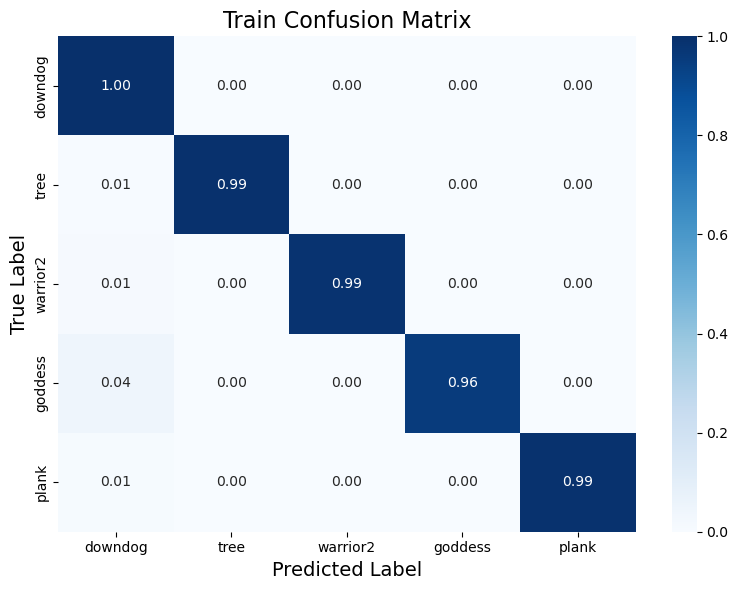

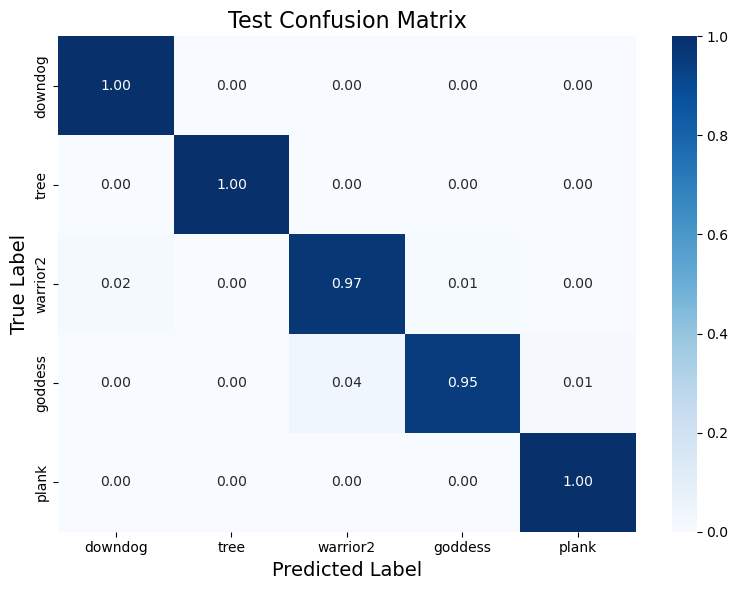

In [45]:
# Train Evaluation
train_acc, train_f1, train_conf_matrix = evaluate_model(model, train_loader, dataset_type="Train")
print("Train Evaluation:")
print(f"Accuracy: {train_acc:.4f}")
print(f"F1 Score: {train_f1:.4f}")

# Test Evaluation
test_acc, test_f1, test_conf_matrix = evaluate_model(model, test_loader, dataset_type="Test")
print("Test Evaluation:")
print(f"Accuracy: {test_acc:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# ---- Plots ----
plot_confusion_matrix(train_conf_matrix, label_map, title="Train Confusion Matrix")
plot_confusion_matrix(test_conf_matrix, label_map, title="Test Confusion Matrix")

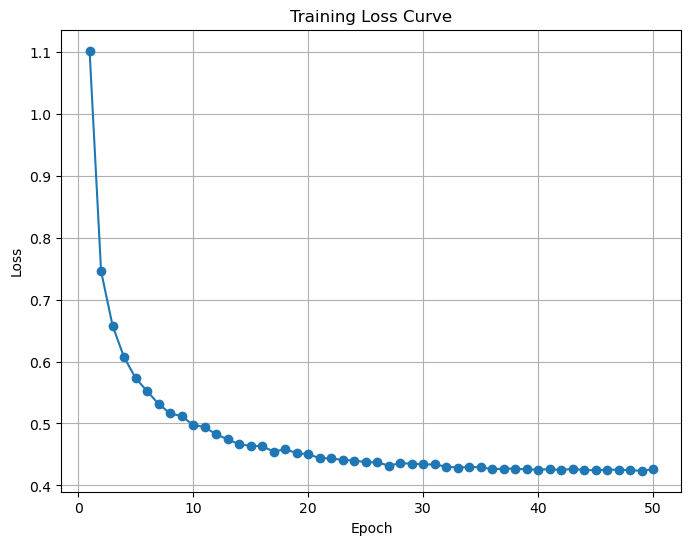

In [47]:
def plot_loss_curve(train_losses):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(train_losses)+1), train_losses, marker='o')
    plt.title('Training Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.show()

plot_loss_curve(train_losses)

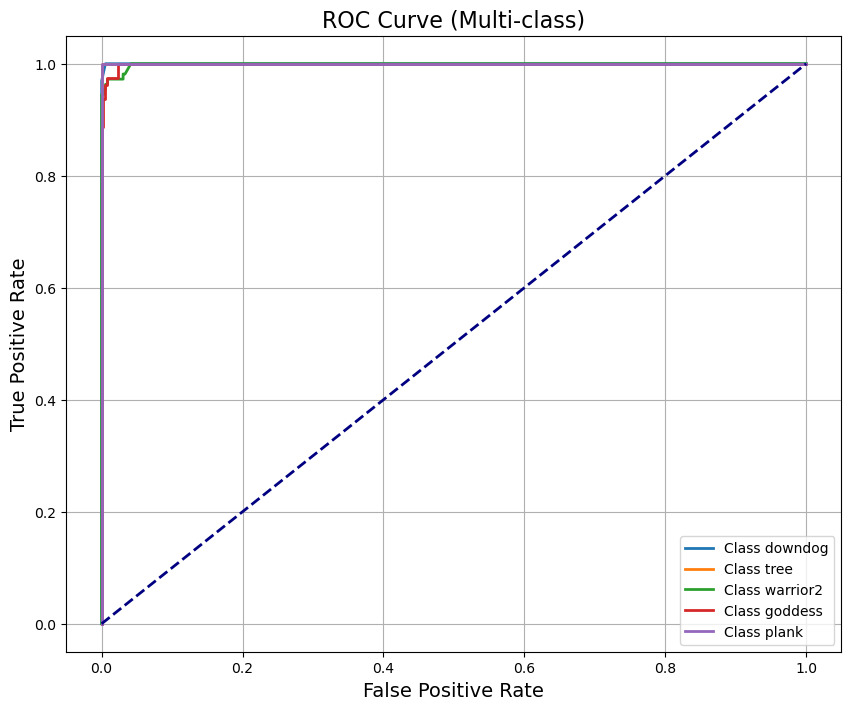

In [49]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, loader, num_classes, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            output = model(data)
            all_preds.append(output.cpu().numpy())
            all_labels.append(data.y.cpu().numpy())

    all_preds = np.vstack(all_preds)
    all_labels = np.hstack(all_labels)
    
    # Binarize the labels for multiclass ROC
    y_true = label_binarize(all_labels, classes=np.arange(num_classes))

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], all_preds[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"Class {class_names[i]}")
    
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("False Positive Rate", fontsize=14)
    plt.ylabel("True Positive Rate", fontsize=14)
    plt.title("ROC Curve (Multi-class)", fontsize=16)
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Example usage after evaluation:
class_names = ['downdog', 'tree', 'warrior2', 'goddess', 'plank']
plot_roc_curve(model, test_loader, num_classes, class_names)

In [51]:
# Later, before UI start (or inside your Tkinter start function)
#model = YogaPoseGAT()  # Initialize the model object
model.load_state_dict(torch.load('pose_model.pth'))
model.eval()
print("Model loaded!")

# UI functions
def start_camera(selected_pose):
    cap = cv2.VideoCapture(1, cv2.CAP_AVFOUNDATION)  # for MacBooks

    if (selected_pose == "goddess"):
        pose_image_path = f"/Users/aananyanagpal/btp/implementation/DATASET/TRAIN/goddess/00000096.jpg"
    if (selected_pose == "downdog"):
        pose_image_path = f"/Users/aananyanagpal/btp/implementation/DATASET/TRAIN/downdog/00000128.jpg"
    if (selected_pose == "plank"):
        pose_image_path = f"/Users/aananyanagpal/btp/implementation/DATASET/TRAIN/plank/00000163.jpg"
    if (selected_pose == "warrior2"):
        pose_image_path = f"/Users/aananyanagpal/btp/implementation/DATASET/TRAIN/warrior2/00000122.jpg"
    if (selected_pose == "tree"):
        pose_image_path = f"/Users/aananyanagpal/btp/implementation/DATASET/TRAIN/tree/00000073.jpg"
    
    try:
        selected_asana_img = cv2.imread(pose_image_path)
        selected_asana_img = cv2.resize(selected_asana_img, (250, 250))  # Increased size
    except Exception as e:
        print(f"Error loading asana image: {e}")
        return

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break

        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(image_rgb)

        if results.pose_landmarks:
            keypoints = np.array([[l.x, l.y, l.z, l.visibility] for l in results.pose_landmarks.landmark])
            keypoints[:, :3] = (keypoints[:, :3] - np.mean(keypoints[:, :3], axis=0)) / (np.std(keypoints[:, :3], axis=0) + 1e-8)
            keypoints[:, 3] = keypoints[:, 3] / np.max(keypoints[:, 3])
            velocity = np.zeros_like(keypoints[:, :3])
            features = np.hstack((keypoints, velocity)).flatten()

            graph = keypoints_to_graph(features, label=0)
            graph = graph.to(device)
            graph.batch = torch.zeros(graph.x.size(0), dtype=torch.long).to(device)

            model.eval()
            with torch.no_grad():
                out = model(graph)
                pred = out.argmax(dim=1).cpu().item()
                detected_pose = idx_to_label[pred]
        else:
            detected_pose = "No Pose"

        # Adjust position to fit the new image size
        frame[10:260, 10:260] = selected_asana_img
        cv2.putText(frame, f"Detected: {detected_pose}", (frame.shape[1] - 350, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
        cv2.imshow("Yoga Pose Detection (GAT Model)", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

Model loaded!


/var/folders/2s/9c6_pfr923l7g6c0wjprpzsc0000gn/T/ipykernel_30025/4280893132.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('pose_model.

In [ ]:
# Pose Selection Window
root = tk.Tk()
root.title("Yoga Pose Detection")
root.geometry("400x400")

pose_label = tk.Label(root, text="Select the Yoga Asana to Perform:", font=("Arial", 16))
pose_label.pack(pady=20)

poses = list(label_map.keys())
selected_pose = tk.StringVar(value=poses[0])

pose_dropdown = ttk.Combobox(root, textvariable=selected_pose, values=poses, state="readonly", font=("Arial", 14))
pose_dropdown.pack(pady=20)
pose_dropdown.bind("<<ComboboxSelected>>", lambda event: selected_pose.set(pose_dropdown.get()))

start_button = tk.Button(root, text="Start Camera", command=lambda: start_camera(selected_pose.get()), font=("Arial", 16))
start_button.pack(pady=30)
start_button.focus_force()   # Force button to take focus immediately

root.mainloop()